# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [49]:
# Import stuff.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from ast import literal_eval

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [50]:
rules_data_path = 'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval
                       },
                       low_memory=True)

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [51]:
# Show the list of column names and the number of rules.
for col in df_rules.columns:
    print(col)

num_of_rules = len(df_rules)
print(f'\nnum_of_rules: {num_of_rules}')


consequent_item
transaction_count
item_set_count
antecedent_count
consequent_count
antecedent_items

num_of_rules: 1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [52]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

#Add new columns by calucalting each one using exisiting columns
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']

df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']

df_rules['lift'] = (df_rules['item_set_count'] * df_rules['transaction_count']) / (df_rules['antecedent_count'] * df_rules['consequent_count'])

print(df_rules.head(50))

                                      consequent_item  transaction_count  \
0   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
1   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
2    Total 0% with Honey Nonfat Greek Strained Yogurt            3346083   
3                           Total 0% Raspberry Yogurt            3346083   
4                                 Pineapple Yogurt 2%            3346083   
5                          Fat Free Strawberry Yogurt            3346083   
6                           Fat Free Blueberry Yogurt            3346083   
7   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
8   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
9   Total 2% Greek Strained Yogurt with Cherry 5.3 oz            3346083   
10  Total 2% All Natural Greek Strained Yogurt wit...            3346083   
11                          Total 0% Raspberry Yogurt            3346083   
12          

The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*

In [53]:
# Query the rule set if you have to to find out more.

print('The support for the products are > 0, indicating the customers bought the product. They also have a high confidence that proves that the support is valid. Since the customers are buying the products first time (high support and confidence) it is more likely that they will come back ')

The support for the products are > 0, indicating the customers bought the product. They also have a high confidence that proves that the support is valid. Since the customers are buying the products first time (high support and confidence) it is more likely that they will come back 


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [54]:
# Define df_rules_subset.

#Rule 1
df_rules_subset = df_rules[df_rules['antecedent_items'].apply(lambda x: len(x) == 1)]
len(df_rules_subset)

#Rule 2
df_rules_subset = df_rules_subset[((df_rules_subset['lift'] <= 20) & (df_rules_subset['lift'] >= 5))]
len(df_rules_subset)

#Rule 3
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(lambda x: x[0])

ante_hummus = df_rules_subset['antecedent_items'].apply(lambda x: 'Hummus' in str(x))
cons_hummus = df_rules_subset['consequent_item'].apply(lambda x: 'Hummus' in str(x))

df_rules_subset = df_rules_subset[(ante_hummus ^ cons_hummus)]

len(df_rules_subset) #This is 25 not 26!

25

Build a network `graph_rules_subset` from the association rules subset.

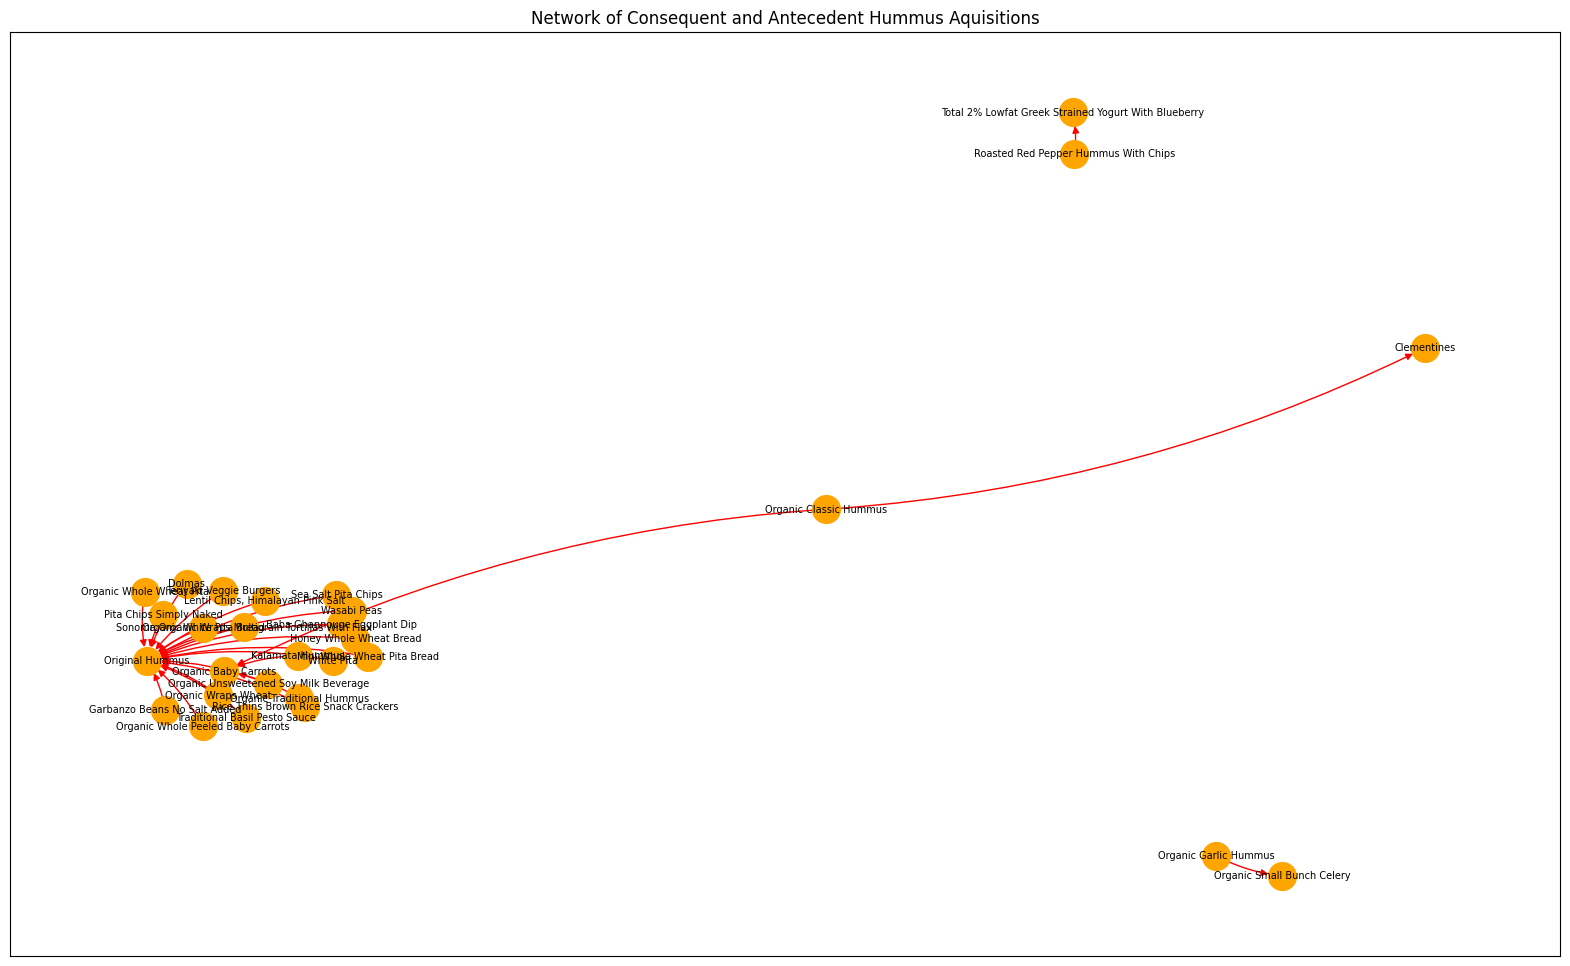

In [55]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()

#Add edges 
edges = []

for index, row in df_rules_subset.iterrows():
    edges.append((row['antecedent_items'], row['consequent_item']))


graph_rules_subset.add_edges_from(edges)

# Then render the graph.
plt.figure(figsize=(20,12))
nx.draw_networkx(graph_rules_subset, 
                 node_size=400, 
                 node_color='orange',
                 font_size=7, 
                 edge_color='red',
                 connectionstyle='arc3, rad=0.1')
plt.title("Network of Consequent and Antecedent Hummus Aquisitions")
plt.show()

#Comment For Self
    #Read documentation on this library and understand more possibilities with this data

What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [56]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

df_rules_subset = df_rules[
    df_rules['antecedent_items'].apply(lambda x: any(item in x for item in basket))
]

# Sort by lift in descending order and get the top 20 predictions
top_20_predictions = df_rules_subset.sort_values('lift', ascending=False).head(20)
print(top_20_predictions)

                                          consequent_item  transaction_count  \
342462      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
345882      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
346832           Nonfat Icelandic Style Strawberry Yogurt            3346083   
346901                           Non Fat Raspberry Yogurt            3346083   
349532      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350852      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350991                           Non Fat Raspberry Yogurt            3346083   
351360      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
351433           Nonfat Icelandic Style Strawberry Yogurt            3346083   
351881      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
352283                         Vanilla Skyr Nonfat Yogurt            3346083   
352884                        Organic Fr

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.